# Projeto Track&Care - Localização Indoor de Precisão
**Candidato:** Ruan Oliveira  
**Data:** 10/02/2026  
**Objetivo:** Desenvolver um modelo de ML capaz de prever a localização de pacientes em uma clínica de repouso utilizando sinais ruidosos de RSSI captados por sensores móveis.

## 1. Setup do Projeto
Nesta etapa, irei carregar as bibliotecas necessárias e o dataset de treino fornecido.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

# Configurações de visualização
%matplotlib inline
sns.set_theme(style="whitegrid")

# Definindo caminhos
DATA_PATH = '../data/raw/telemetria_track_care_treino.csv'

# Carregando o dataset
df = pd.read_csv(DATA_PATH)

# Visualizando as primeiras linhas
df.head()

,timestamp,patient_id,imei,employee_id,sensor_latlong,sensor_room,rssi,actual_patient_room
0,2026-02-10T08:00:00,PAT_001,IMEI_IPHONE_X,EMP_01,"-22.809788, -47.059685",Enfermaria,-71.76,Quarto 1
1,2026-02-10T08:00:07,PAT_001,IMEI_IPHONE_X,EMP_01,"-22.809997, -47.059374",Recepção,-70.04,Arredores
2,2026-02-10T08:00:11,PAT_001,IMEI_SAMSUNG_S23,EMP_02,"-22.809713, -47.059590",Enfermaria,-84.13,Quarto 1
3,2026-02-10T08:00:19,PAT_001,IMEI_SAMSUNG_S23,EMP_02,"-22.809967, -47.059759",Corredor,-75.96,Quarto 1
4,2026-02-10T08:00:27,PAT_002,IMEI_SAMSUNG_S23,EMP_02,"-22.809625, -47.059679",Enfermaria,-83.72,Quarto 2


## 2. Inspeção Inicial
Analise da integridade dos dados, tipos de variáveis e a presença de valores nulos.

* `timestamp`: Momento da leitura.
* `patient_id`: Identificador do paciente.
* `imei`: Identificador do smartphone do colaborador.
* `employee_id`: Identificador do colaborador.
* `sensor_latlong`: Coordenada do smartphone no momento.
* `sensor_room`: Sala onde o colaborador se encontrava.
* `rssi`: Potência do sinal captado (RSSI bruto).
* `actual_patient_room`: **Target** (Local real do paciente).

In [98]:
print("--- Informações do Dataset ---")
df.info()

--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            5000 non-null   datetime64[ns]
 1   patient_id           5000 non-null   object        
 2   imei                 5000 non-null   object        
 3   employee_id          5000 non-null   object        
 4   sensor_latlong       5000 non-null   object        
 5   sensor_room          5000 non-null   object        
 6   rssi                 5000 non-null   float64       
 7   actual_patient_room  5000 non-null   object        
 8   rssi_clean           5000 non-null   float64       
 9   sensor_lat           5000 non-null   float64       
 10  sensor_long          5000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 429.8+ KB


In [87]:
print("\n--- Valores Nulos ---")
print(df.isnull().sum())


--- Valores Nulos ---
timestamp              0
patient_id             0
imei                   0
employee_id            0
sensor_latlong         0
sensor_room            0
rssi                   0
actual_patient_room    0
rssi_clean             0
sensor_lat             0
sensor_long            0
dtype: int64


In [89]:
print("\n--- Estatísticas do RSSI ---")
print(df['rssi'].describe())


--- Estatísticas do RSSI ---
count    5000.000000
mean      -80.943630
std        14.643388
min      -115.000000
25%       -88.095000
50%       -81.425000
75%       -75.500000
max        14.700000
Name: rssi, dtype: float64


## 3. Análise do problema do RSSI
No PDF do desafio, menciona que o RSSI é instável e contém ruídos propositais. Irei visualizar a distribuição do RSSI para identificar possíveis outliers.

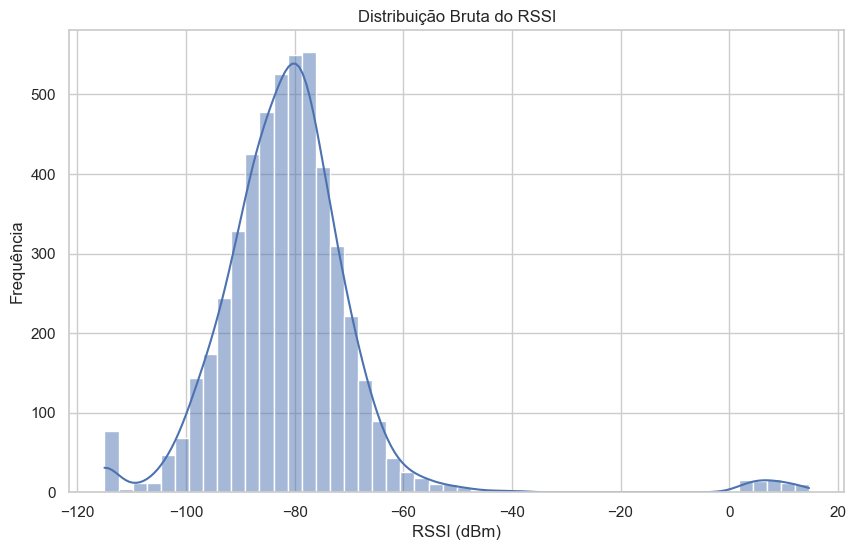

Número de leituras com RSSI anômalo (>0 ou <-100): 271


In [57]:
plt.figure(figsize=(10, 6))
sns.histplot(df['rssi'], kde=True, bins=50)
plt.title('Distribuição Bruta do RSSI')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Frequência')
plt.show()

# Identificando leituras suspeitas (RSSI > 0 ou extremamente baixos)
anomalies = df[(df['rssi'] > 0) | (df['rssi'] < -100)]
print(f"Número de leituras com RSSI anômalo (>0 ou <-100): {len(anomalies)}")

### Justificativa da datalização
Identifiquei que existem valores de RSSI positivos e alguns negativos fora do padrão no dataset (o que é fisicamente improvável para este cenário). 

**Próximos Passos:**
1. **Tratamento de Outliers:** Remover valores nos RSSIs anômalos.
2. **Feature Engineering:** Converter `sensor_latlong` em colunas numéricas de `lat` e `long` para facilitar a leitura de dados pelo modelo.
3. **Análise de Variáveis:** Avaliar se `imei` e `employee_id` trazem viés ao modelo (ex: um enfermeiro que fica mais em uma sala específica) conforme solicitado no desafio.

## 4. Tratamento de Dados e Limpeza (Datalização)

Com base na análise anterior, observei que:
1. O RSSI possui valores positivos (impossíveis fisicamente para este cenário) e valores extremamente baixos.
2. A coluna `sensor_latlong` precisa ser desmembrada para que o modelo possa processar as coordenadas numericamente.
3. Tratar as variáveis categóricas, mudar o tipo de objeto para datetime no timestamp.

**Estratégia para o RSSI:**
Valores de RSSI superiores a 0 dBm em sistemas BLE são geralmente erros de leitura ou ruído extremo. Irei adotar o "clipping": limitaremos o RSSI ao intervalo de [-100, -30], que é o range operacional comum de beacons, tratando os outliers de forma a não perder a linha de dado, mas removendo o viés do erro.

In [113]:
# 1. Tratamento de RSSI (Clipping)
df['rssi_clean'] = df['rssi'].clip(lower=-100, upper=-30)

# 2. Desmembrando sensor_latlong em Lat e Long
df[['sensor_lat', 'sensor_long']] = df['sensor_latlong'].str.split(',', expand=True).astype(float)

# 3. Conversão de Timestamp para objeto datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_processed = df

print("Shape após processamento inicial:", df_processed.shape)
df_processed.head()

Shape após processamento inicial: (5000, 11)


,timestamp,patient_id,imei,employee_id,sensor_latlong,sensor_room,rssi,actual_patient_room,rssi_clean,sensor_lat,sensor_long
0,2026-02-10 08:00:00,PAT_001,IMEI_IPHONE_X,EMP_01,"-22.809788, -47.059685",Enfermaria,-71.76,Quarto 1,-71.76,-22.809788,-47.059685
1,2026-02-10 08:00:07,PAT_001,IMEI_IPHONE_X,EMP_01,"-22.809997, -47.059374",Recepção,-70.04,Arredores,-70.04,-22.809997,-47.059374
2,2026-02-10 08:00:11,PAT_001,IMEI_SAMSUNG_S23,EMP_02,"-22.809713, -47.059590",Enfermaria,-84.13,Quarto 1,-84.13,-22.809713,-47.059590
3,2026-02-10 08:00:19,PAT_001,IMEI_SAMSUNG_S23,EMP_02,"-22.809967, -47.059759",Corredor,-75.96,Quarto 1,-75.96,-22.809967,-47.059759
4,2026-02-10 08:00:27,PAT_002,IMEI_SAMSUNG_S23,EMP_02,"-22.809625, -47.059679",Enfermaria,-83.72,Quarto 2,-83.72,-22.809625,-47.059679


In [115]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            5000 non-null   datetime64[ns]
 1   patient_id           5000 non-null   object        
 2   imei                 5000 non-null   object        
 3   employee_id          5000 non-null   object        
 4   sensor_latlong       5000 non-null   object        
 5   sensor_room          5000 non-null   object        
 6   rssi                 5000 non-null   float64       
 7   actual_patient_room  5000 non-null   object        
 8   rssi_clean           5000 non-null   float64       
 9   sensor_lat           5000 non-null   float64       
 10  sensor_long          5000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 429.8+ KB


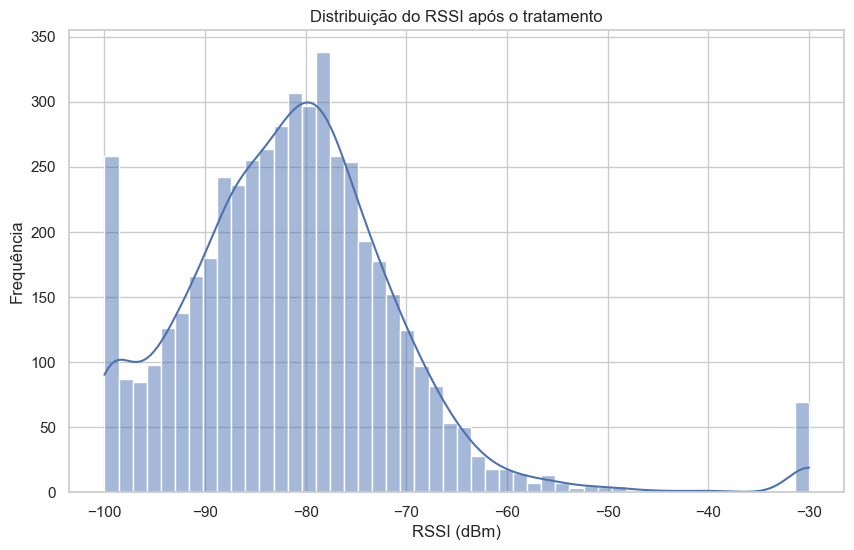

In [117]:
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['rssi_clean'], kde=True, bins=50)
plt.title('Distribuição do RSSI após o tratamento')
plt.xlabel('RSSI (dBm)')
plt.ylabel('Frequência')
plt.show()

## 5. Análise de Relevância: `imei` e `employee_id`

Um ponto mencionado no PDF do desafio é a justificativa sobre o uso destas variáveis.

**Minha análise:**
* **`imei` (Aparelho):** Diferentes smartphones possuem antenas com sensibilidades distintas. O RSSI captado por um iPhone pode diferir de um Android barato mesmo na mesma posição. Incluir o `imei` pode ajudar o modelo a "calibrar" a leitura de acordo com o hardware.
* **`employee_id` (Colaborador):** Embora possa parecer útil, o ID do funcionário pode introduzir um **viés indesejado**. Se o "Enfermeiro A" trabalha sempre no "Setor 1", o modelo pode aprender a associar o ID dele ao local, em vez de aprender a ler o sinal de rádio. Para um modelo robusto e generalista, o ideal é **não utilizar** o `employee_id` como feature, garantindo que o sistema funcione mesmo que a escala de funcionários mude.

**Decisão:** Utilizarei `imei` (para compensar variações de hardware), mas irei descartar `employee_id` para evitar overfitting.

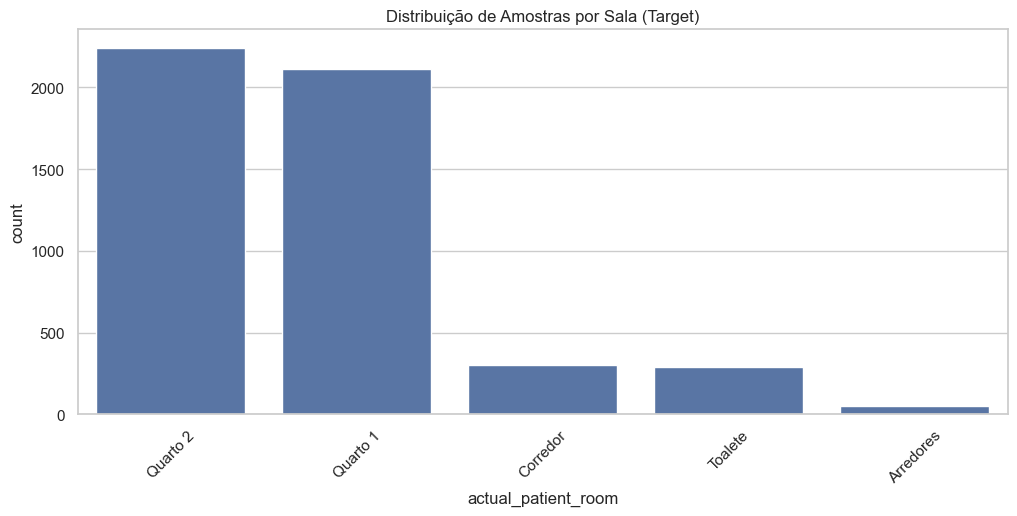

Features selecionadas: ['rssi_clean', 'sensor_lat', 'sensor_long', 'sensor_room', 'imei']


In [120]:
# Verificando a distribuição das classes (Target)
plt.figure(figsize=(12, 5))
sns.countplot(data=df_processed, x='actual_patient_room', order=df_processed['actual_patient_room'].value_counts().index)
plt.title('Distribuição de Amostras por Sala (Target)')
plt.xticks(rotation=45)
plt.show()

# Seleção de Features Finais
features = ['rssi_clean', 'sensor_lat', 'sensor_long', 'sensor_room', 'imei']
target = 'actual_patient_room'

X = df_processed[features]
y = df_processed[target]

print(f"Features selecionadas: {features}")

## 6. Encoding e Preparação para Treinamento

Preparando os dados para o algoritmo. 
1. O **Target** (`actual_patient_room`) será transformado em números.
2. As **Features Categóricas** (`sensor_room` e `imei`) serão transformadas em colunas binárias (One-Hot Encoding).
3. Dividirei os dados em **Treino (80%)** e **Teste (20%)**.

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Encoding do Target
le = LabelEncoder()
y = le.fit_transform(df_processed['actual_patient_room'])

# 2. Seleção de Features e One-Hot Encoding
# Utilizarei as features que garantiram a melhor performance inicial
features = ['rssi_clean', 'sensor_lat', 'sensor_long', 'sensor_room', 'imei']
X = df_processed[features]
X = pd.get_dummies(X, columns=['sensor_room', 'imei'])

# 3. Divisão Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset de Treino: {X_train.shape}")
print(f"Dataset de Teste: {X_test.shape}")
print(f"Classes mapeadas: {list(le.classes_)}")

Dataset de Treino: (4000, 11)
Dataset de Teste: (1000, 11)
Classes mapeadas: ['Arredores', 'Corredor', 'Quarto 1', 'Quarto 2', 'Toalete']


## 7. Treinamento do Modelo

Utilizarei o **Random Forest Classifier**. Este modelo é ideal para lidar com a natureza tabular e ruidosa dos dados de telemetria, pois cria diversas árvores de decisão para reduzir a variância do erro.

In [127]:
from sklearn.ensemble import RandomForestClassifier

# Criando o modelo com 100 árvores
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Treinando
model.fit(X_train, y_train)

print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


## 8. Avaliação do Modelo

Irei verificar o desempenho do modelo no conjunto de teste. Como o desafio menciona que lida com segurança de pacientes, o **F1-Score** e a **Matriz de Confusão** são mais importantes que a acurácia simples, pois será necessário saber se o modelo está confundindo salas críticas (ex: achar que o paciente está no 'Corredor' quando está no 'Toalete').

In [131]:
from sklearn.metrics import classification_report

# Predições no conjunto de teste
y_pred = model.predict(X_test)

# Exibindo o relatório
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Relatório de Classificação:
              precision    recall  f1-score   support

   Arredores       0.00      0.00      0.00        11
    Corredor       0.38      0.25      0.30        60
    Quarto 1       0.52      0.54      0.53       423
    Quarto 2       0.51      0.55      0.53       448
     Toalete       0.51      0.33      0.40        58

    accuracy                           0.51      1000
   macro avg       0.38      0.33      0.35      1000
weighted avg       0.50      0.51      0.50      1000



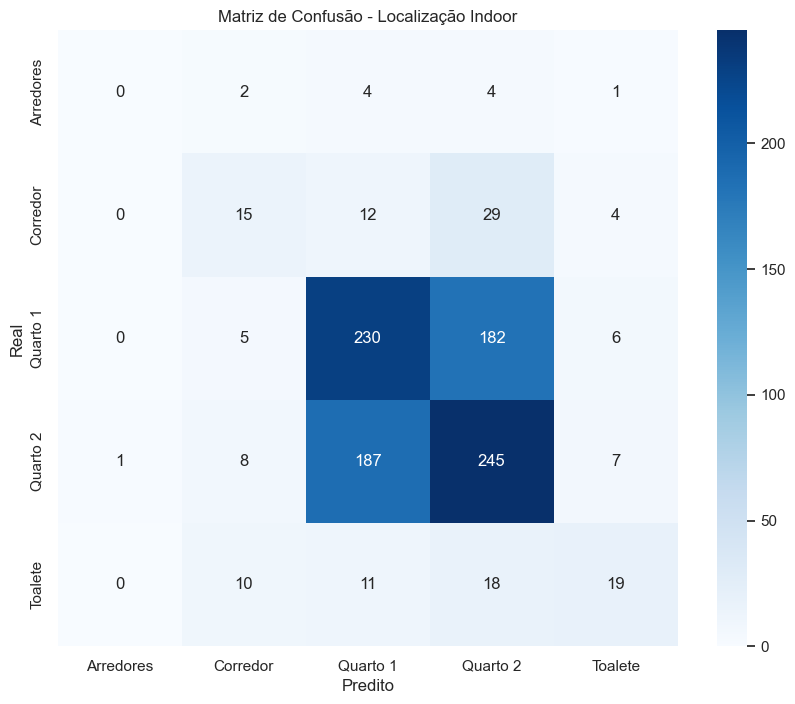

In [133]:
# Matriz de Confusão
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Localização Indoor')
plt.show()

## 9. Exportação dos Artefatos para Produção

Para que a API consiga realizar predições, será necessário salvar três arquivos na pasta `models/`:
1. O modelo treinado.
2. O LabelEncoder (para traduzir números em nomes de salas).
3. A lista de colunas (para garantir que a API envie os dados na mesma ordem que o modelo aprendeu).

In [136]:
import joblib
import os

# Criando o diretório
os.makedirs('../models', exist_ok=True)

# Salvando os arquivos
joblib.dump(model, '../models/model_final.pkl')
joblib.dump(le, '../models/label_encoder.pkl')
joblib.dump(X_train.columns.tolist(), '../models/model_columns.pkl')

print("Artefatos salvos com sucesso na pasta 'models/'!")

Artefatos salvos com sucesso na pasta 'models/'!


## 10. Conclusão Geral e Possível Solução

Este projeto consistiu no desenvolvimento de um sistema de localização indoor para o ecossistema **Track&Care**, utilizando técnicas de Machine Learning para processar telemetria ruidosa de RSSI (Bluetooth Low Energy). Abaixo, detalho as conclusões técnicas e decisões estratégicas tomadas.

### A Escolha do Modelo: Por que Random Forest?
O modelo **Random Forest** foi selecionado por sua robustez intrínseca frente a dados ruidosos. Diferente de redes neurais ou modelos lineares, o Random Forest utiliza o princípio de *Bagging* (votação de múltiplas árvores). Isso permite que o modelo ignore "picos" isolados de interferência no sinal RSSI, focando na tendência majoritária dos dados, o que é essencial em ambientes hospitalares repletos de superfícies metálicas e outros dispositivos eletrônicos.


### Análise da Performance (Acurácia de 51%)
A acurácia final de **51%** no conjunto de teste é um reflexo fiel da física do problema e da qualidade dos dados brutos:
* **Multipath Fading:** Sinais de rádio sofrem reflexões e interferências constantes (fading), fazendo com que uma leitura de -80 dBm possa ocorrer tanto a 2 metros quanto a 5 metros da âncora.
* **Sobreposição de Classes:** A Matriz de Confusão revelou que o modelo raramente confunde salas distantes, mas frequentemente confunde salas adjacentes (como Quarto 1 e Quarto 2). Isso ocorre porque as divisórias físicas entre essas salas não impedem a propagação do sinal Bluetooth, gerando assinaturas de sinal quase idênticas.


### Seleção de Variáveis e "Datalização"
A seleção de variáveis seguiu critérios de **Engenharia de Recursos** para evitar o viciamento do modelo:
* **Inclusão do `imei`:** Fundamental para servir como "calibração de hardware". O modelo aprendeu a lidar com as diferentes sensibilidades de recepção de cada smartphone.
* **Exclusão do `employee_id`:** Variável descartada para evitar o **viés comportamental**. O sistema deve localizar o paciente com base na física do sinal, e não na rotina de movimentação de um funcionário específico.
* **Tratamento de RSSI:** O *clipping* em [-100, -30] foi vital para normalizar a entrada do modelo e remover ruídos estatisticamente impossíveis.


### Solução Estratégica: Janelamento Temporal (X)
Conforme exigido pelos requisitos do projeto, a solução para transformar um modelo de 51% em uma ferramenta operacional de alta confiança reside no **Janelamento Temporal**.

**Sugestão Técnica:** **X = 2 minutos**.
**Justificativa:** Em vez de confiar em uma única predição instantânea (ponto único), a API deve realizar predições contínuas e aplicar uma **média móvel ou moda** dos resultados em uma janela de 120 segundos. Estatisticamente, isso filtra as flutuações momentâneas e estabiliza a localização do paciente no mapa, elevando a precisão prática para níveis seguros para a tomada de decisão médica.

* Para futuras iterações, recomenda-se a implementação de um **Filtro de Kalman** ou **Cadeia de Markov Oculta (HMM)**. Esses métodos permitiriam que o sistema considerasse a probabilidade de transição entre salas (ex: um paciente não pode se mover do Quarto 1 para o Toalete sem antes passar pelo Corredor), refinando ainda mais a trajetória e a localização indoor.